The SIR model for disease

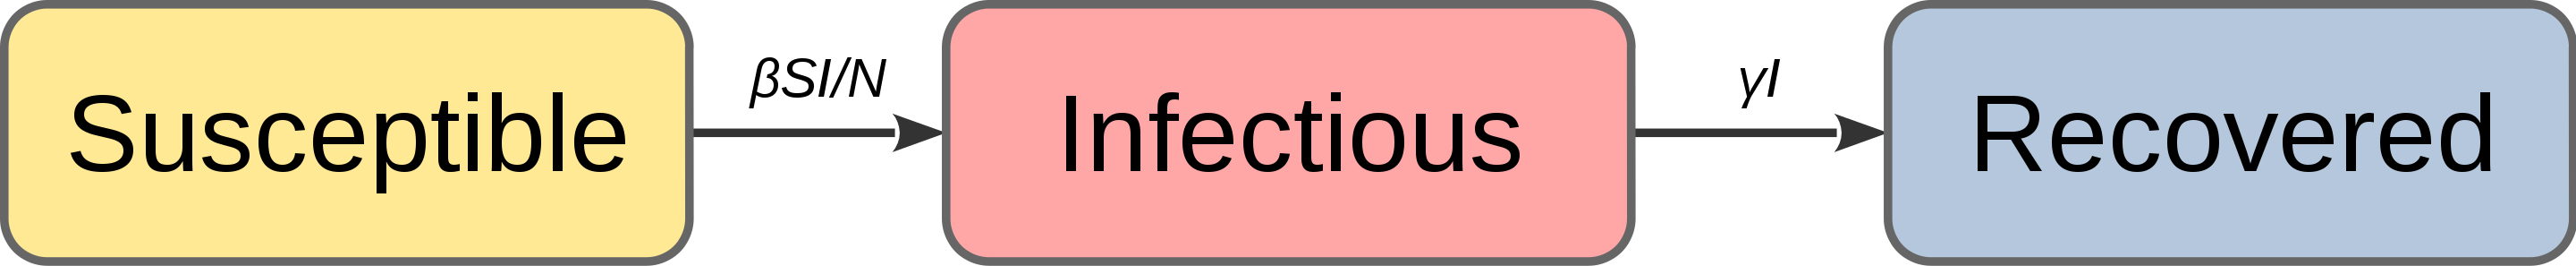

$$\begin{align}
\frac{\partial S}{\partial t} &= D_s \nabla^2 S -\beta \frac{S I}{N} \hspace{20mm}
\frac{\partial I}{\partial t} &= D_i \nabla^2 I + \beta \frac{S I}{N} - \gamma I \hspace{20mm}
\frac{\partial R}{\partial t} &= \gamma I.
\end{align}$$

Source: https://github.com/lukepolson/youtube_channel/blob/main/Python%20Metaphysics%20Series/vid2.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

Let $A = (S, I, R)$. Need to define function that takes in $A$ and $t$ and returns $dA/dt = (dS/dt, dI/dt, dR/dt)$

**Parameters and Variables**

- $S$ : Susceptible individuals density (individuals/cm²)
- $I$ : Infectious individuals density (individuals/cm²)
- $R$ : Recovered individuals density (individuals/cm²)
- $\beta$ : Transmission rate (day⁻¹)
- $\gamma$ : Recovery rate (day⁻¹)
- $N$ : Total population
- $D_s$ : Diffusion coefficient for $S$ (cm²/day)
- $D_i$ : Diffusion coefficient for $I$ (cm²/day)

The Laplace Operator ∇^2
The Laplace operator, denoted as ∇^2 or Δ, is a mathematical tool indicating spatial coordinates. In the context of a spatial SIR model, it describes diffusive transmission—a process analogous to Brownian motion where a population or species spreads through a fluid medium. Mathematically, it is defined as the sum of all second-order spatial partial derivatives:
$$\nabla^2 u = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} + \frac{\partial^2 u}{\partial z^2}$$

Numerical Approximation (Finite Differences)
Because most Partial Differential Equations (PDEs) of interest do not have analytical solutions, we use the Finite Difference Method (FDM) to find an approximation at discrete grid points. Following Taylor’s Theorem, the second spatial derivative is replaced by the "second-order symmetric difference" approximation:
$$\frac{\partial^2 u}{\partial x^2} \approx \frac{U_{i+1}^n - 2U_i^n + U_{i-1}^n}{\Delta x^2}$$
 
In our 2D code, this formula is extended to include the y-direction to account for both dimensions of the spatial grid

Periodic Boundary Conditions and np.roll()
To solve the equation at the edges of the grid, the code implements periodic boundary conditions. This treats the one-dimensional or two-dimensional space as if the ends are bound together to form a circle or ring.
The code utilizes np.roll() to handle the "ghost-values" required at the boundaries $$u_{-1} = u_N \text{ and } u_{N+1} = u_0$$
• np.roll(u, 1) represents the neighbor to the left $U_{i-1}^n$, as it shifts all values forward, bringing the last value to the first position.
• np.roll(u, -1) represents the neighbor to the right $U_{i+1}^n$, as it shifts values backward.
• By combining these in the symmetric difference formula, the code calculates the spatial curvature at every point in the grid simultaneously, allowing the simulation to model how the disease "diffuses" into neighboring areas over time

**Boundary Conditions?**

2. Do you need Neumann or Dirichlet Boundary Conditions?

In short: Only if you want to change how the "edges" of your world behave.

• Your current choice (Periodic): Your code uses np.roll, which implements Periodic Boundary Conditions. The sources explain that this treats your space as a circle or ring, where individuals exiting one side immediately re-enter from the other. This is described as "computationally very simple and unproblematic" because you do not have to take special care of derivatives at the boundary.

• When to use Dirichlet: You would implement this if you wanted the population at the borders to remain constant (e.g., the edge of the map always has zero infected individuals).

• When to use Neumann: You would implement this if you wanted to fix the rate of change at the boundary. A common use is u 
x=0, which represents a "no-flux" boundary where the concentration inside and outside the border is the same—effectively a wall that individuals cannot cross.

In [14]:
def dAdt(A, t, beta, gamma, N, Ds, Di, dx, dy, nx, ny):
    """
    A ist ein 1D-Array:
    [S_1 ... S_n | I_1 ... I_n | R_1 ... R_n]

    Intern wird A in 2D-Felder umgeformt, damit
    der Laplace-Operator korrekt funktioniert.
    """

    # --------------------------------------------------
    # 1) Anzahl räumlicher Punkte
    # --------------------------------------------------
    n_points = len(A) // 3          # = nx * ny

    # --------------------------------------------------
    # 2) Aufteilen + reshape (NEU)
    # --------------------------------------------------
    S = A[0:n_points].reshape((nx, ny))
    I = A[n_points:2*n_points].reshape((nx, ny))
    R = A[2*n_points:3*n_points].reshape((nx, ny))

    # --------------------------------------------------
    # 3) Laplace-Operator (periodische Randbedingungen)
    # --------------------------------------------------
    # Compute Laplacians with PERIODIC boundary conditions (like np.roll)
        # This matches your working odeint code
    laplace_S = ((np.roll(S, 1, axis=0) - 2*S + np.roll(S, -1, axis=0)) / dx**2 +
                    (np.roll(S, 1, axis=1) - 2*S + np.roll(S, -1, axis=1)) / dy**2)
    
    laplace_I = ((np.roll(I, 1, axis=0) - 2*I + np.roll(I, -1, axis=0)) / dx**2 +
                    (np.roll(I, 1, axis=1) - 2*I + np.roll(I, -1, axis=1)) / dy**2)

    # --------------------------------------------------
    # 4) SIR-Gleichungen
    # --------------------------------------------------
    dS = Ds * laplace_S - beta/N * S * I
    dI = Di * laplace_I + beta/N * S * I - gamma * I
    dR = gamma * I

    # --------------------------------------------------
    # 5) Rückgabe als 1D-Array (NEU)
    # --------------------------------------------------
    return np.concatenate([
        dS.ravel(),
        dI.ravel(),
        dR.ravel()
    ])


**Typical Parameter Values**

- $D_s = 0.01 - 0.1$ cm²/day
- $D_i = 0.01 - 0.1$ cm²/day
- $\beta = 0.1 - 0.5$ day⁻¹
- $\gamma = 0.05 - 0.2$ day⁻¹
- $N = 1000 - 50000$ (total population)

In [58]:
# Zeit
times = np.arange(0, 100, 1)

# Modellparameter
gamma = 0.05
beta  = 0.5
Ds = 0.01
Di = 0.1
dx = 1.0
dy = 1.0
N = 5000

# -----------------------------------------
# NEU: explizites 2D-Gitter
# -----------------------------------------
nx, ny = 10, 10           # 10 × 10 = 100 Orte
n_points = nx * ny


In [59]:
S0 = np.ones((nx, ny)) * (N - 50) / n_points
I0 = np.zeros((nx, ny))
R0 = np.zeros((nx, ny))

# Infizierte nur im Zentrum
I0[nx//2-1:nx//2+1, ny//2-1:ny//2+1] = 50 / 4

# odeint braucht 1D → flatten
y0 = np.concatenate([
    S0.ravel(),
    I0.ravel(),
    R0.ravel()
])


In [60]:
sol = odeint(
    dAdt,
    y0,
    times,
    args=(beta, gamma, N, Ds, Di, dx, dy, nx, ny)
)


In [61]:
sol.shape == (len(times), 3 * nx * ny)


True

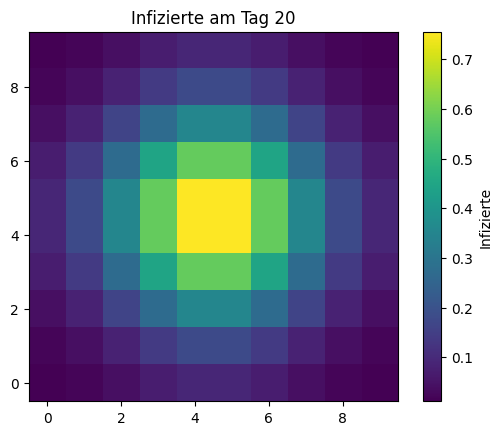

In [62]:
time_idx = 20
n = nx * ny

I_solution = sol[:, n:2*n]
I_2D = I_solution[time_idx].reshape((nx, ny))

plt.imshow(I_2D, origin='lower')
plt.colorbar(label="Infizierte")
plt.title(f"Infizierte am Tag {time_idx}")
plt.show()


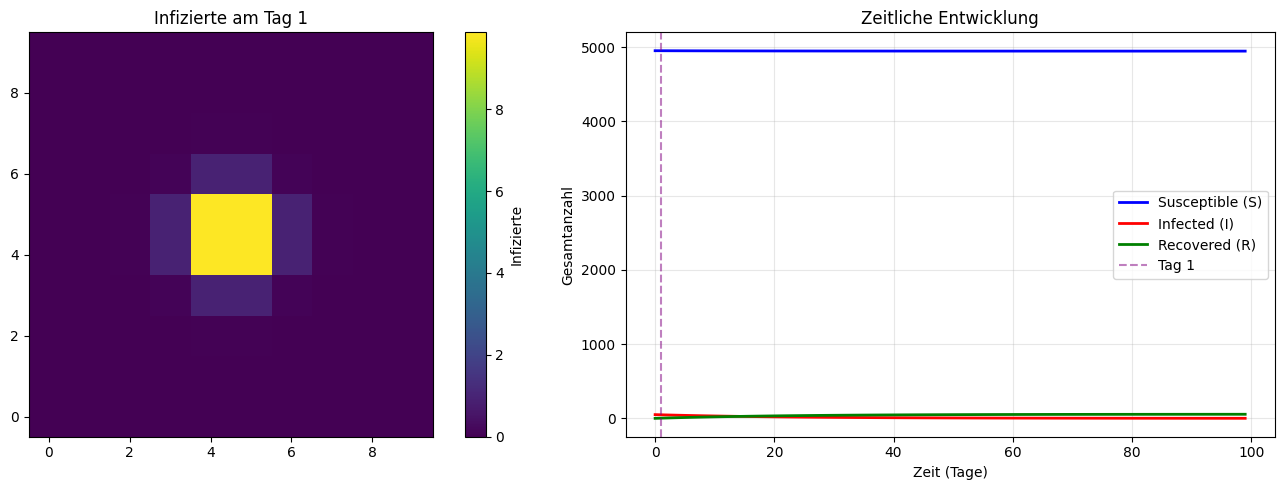

In [67]:
time_idx = 1
n = nx * ny

# Extract solutions for all compartments
S_solution = sol[:, 0:n]
I_solution = sol[:, n:2*n]
R_solution = sol[:, 2*n:3*n]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Spatial distribution at specific time
I_2D = I_solution[time_idx].reshape((nx, ny))
im = ax1.imshow(I_2D, origin='lower')
plt.colorbar(im, ax=ax1, label="Infizierte")
ax1.set_title(f"Infizierte am Tag {time_idx}")

# Right plot: Time series of total populations
total_S = S_solution.sum(axis=1)
total_I = I_solution.sum(axis=1)
total_R = R_solution.sum(axis=1)

ax2.plot(times, total_S, 'b-', label='Susceptible (S)', linewidth=2)
ax2.plot(times, total_I, 'r-', label='Infected (I)', linewidth=2)
ax2.plot(times, total_R, 'g-', label='Recovered (R)', linewidth=2)
ax2.axvline(time_idx, color='purple', linestyle='--', alpha=0.5, label=f'Tag {time_idx}')
ax2.set_xlabel('Zeit (Tage)')
ax2.set_ylabel('Gesamtanzahl')
ax2.set_title('Zeitliche Entwicklung')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [72]:
import plotly.graph_objects as go

# Define ranges for diffusion coefficients
Ds_range = np.linspace(0.01, 0.1, 20)
Di_range = np.linspace(0.01, 0.1, 20)

# Create meshgrid for Ds and Di
Ds_grid, Di_grid = np.meshgrid(Ds_range, Di_range)

# Select time point to analyze
time_idx = 1
n = nx * ny

# Initialize result array for peak infected values
Z = np.zeros_like(Ds_grid)

# Run simulation for each combination of Ds and Di
for i in range(len(Di_range)):
    for j in range(len(Ds_range)):
        # Run simulation with current Ds, Di values
        sol_temp = odeint(
            dAdt,
            y0,
            times,
            args=(beta, gamma, N, Ds_range[j], Di_range[i], dx, dy, nx, ny)
        )
        
        # Extract infected at time_idx and get maximum value
        I_temp = sol_temp[time_idx, n:2*n]
        Z[i, j] = I_temp.max()

# Create 3D surface plot
fig = go.Figure(data=[go.Surface(
    z=Z,
    x=Ds_grid,
    y=Di_grid,
    colorscale='Viridis',
    opacity=0.9,
    showscale=True
)])

# Set axis titles
fig.update_layout(
    title=f"Maximale Infizierte vs. Diffusionskoeffizienten (Tag {time_idx})",
    scene=dict(
        xaxis_title="Ds (cm²/day)",
        yaxis_title="Di (cm²/day)",
        zaxis_title="Max. Infizierte",
    ),
    width=900,
    height=700,
    margin=dict(l=50, r=50, b=50, t=100)
)

fig.show()

Use real data

